In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from torchviz import make_dot
from tqdm import tqdm

In [3]:
class Optimizer(nn.Module):
    
    def __init__(self, hidden_size = 20):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTMCell(1, self.hidden_size)
        self.lstm2 = nn.LSTMCell(self.hidden_size, self.hidden_size)
        self.output = nn.Linear(self.hidden_size, 1)
        
    def forward(self, inp, state = None):
        if state==None:
            hx, cx = torch.zeros(inp.size(0), self.hidden_size), torch.zeros(inp.size(0), self.hidden_size)
        else:
            hx, cx = state
        hx, cx = self.lstm1(inp, (hx,cx))
        hx, cx = self.lstm2(hx, (hx, cx))
        gt = self.output(hx)
        return gt, (hx,cx)

In [126]:
class Quadratic(nn.Module):
    
    def __init__(self, seed = 0, **kwargs):
        super().__init__()
        torch.manual_seed(seed)
        self.W = torch.randn(size=(10,10))
        self.y = torch.randn(size=(10,1))
        self.theta = nn.Parameter(torch.randn(size=(10,1)))
    
    def opt_theta(self):
        return torch.linalg.inv(self.W) @ self.y 
        
    def forward(self, x):
        return nn.MSELoss(reduction='sum')(torch.mm(self.W, x), self.y)

In [149]:
meta_opt = Optimizer()
quad_cls = Quadratic()

In [158]:
meta_opt = Optimizer()
quad_cls = Quadratic()

x = quad_cls.theta
q_loss = quad_cls(x)
q_loss.backward() #this populated x.grad

print([z.grad for z in meta_opt.parameters()]) 
#output is: [None, None, None, None, None, None, None, None, None, None]

update, state = meta_opt(x.grad, None)

x = x + update.clone().detach()

m_loss = quad_cls(x)
m_loss.backward()

print([z.grad for z in meta_opt.parameters()]) 
#output is still: [None, None, None, None, None, None, None, None, None, None]

[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None]


In [154]:
def learn(optimizer, optimizee, unroll_steps, old_state=None):
    
    x = optimizee.theta.clone().detach()
    global_loss = 0
    state = None if old_state is None else old_state
    x.requires_grad_()
    losses = []

    for i in range(unroll_steps):

        loss = optimizee(x)
        global_loss += loss
        
        loss.backward(retain_graph=True) #populate/update the grad of f wrt x
        
        update, state = optimizer(x.grad, state)
        losses.append(float(loss.item()))
        
        x = update
        x.retain_grad()

    return losses, global_loss, state

In [155]:
meta_opt = Optimizer()
quad_cls = Quadratic()

In [156]:
def trainL2O(optimizee_cls, optimizer_obj, num_functions, unroll_length = 20, iterations = 100, meta_lr = 0.001):
    
    meta_opt = optimizer_obj
    avg_loss_funcs = np.zeros((num_functions, iterations))
    for n_func in tqdm(range(num_functions)):
        
        quad_cls = optimizee_cls(seed=n_func)
        global_optimizer = torch.optim.SGD(meta_opt.parameters(), lr = meta_lr)
        state = None
        
        for iter in range(iterations):
            # Compute global loss
            loss_vec_unroll, global_loss, state = learn(meta_opt, 
                                                        quad_cls, 
                                                        unroll_steps=unroll_length, 
                                                        old_state=state)

            # Zero the gradients of the global optimizer
            global_optimizer.zero_grad()

            # Backpropagate gradients through global loss
            global_loss.backward()

            # Update the parameters of the global optimizer
            global_optimizer.step()

            avg_loss_funcs[n_func, iter] = np.mean(loss_vec_unroll)

    return avg_loss_funcs.mean(axis=0)

In [157]:
avg_loss = trainL2O(optimizee_cls = Quadratic, 
                    optimizer_obj = meta_opt, 
                    num_functions = 25,
                    unroll_length = 20, 
                    iterations = 100, 
                    meta_lr = .001)

  0%|                                                                                                            | 0/25 [00:00<?, ?it/s]


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [20, 80]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [47]:
quad_cls(quad_cls.theta)

tensor(86.9042)

In [43]:
[x for x in meta_opt.parameters()]

[Parameter containing:
 tensor([[ 0.1395],
         [-0.1750],
         [-0.0473],
         [-0.0907],
         [-0.0431],
         [-0.0439],
         [-0.2007],
         [-0.1931],
         [-0.0350],
         [ 0.0029],
         [-0.1016],
         [ 0.0842],
         [-0.2013],
         [-0.0151],
         [ 0.1966],
         [-0.0912],
         [ 0.2019],
         [ 0.0810],
         [-0.2018],
         [ 0.1415],
         [-0.0258],
         [-0.0998],
         [ 0.1788],
         [-0.1807],
         [ 0.0240],
         [-0.0468],
         [ 0.1597],
         [ 0.0624],
         [ 0.1074],
         [ 0.0790],
         [-0.0538],
         [-0.0470],
         [-0.1843],
         [ 0.1212],
         [ 0.1775],
         [ 0.1530],
         [-0.1577],
         [ 0.0100],
         [-0.1576],
         [-0.1231],
         [-0.1303],
         [ 0.0764],
         [-0.1333],
         [-0.0049],
         [ 0.0094],
         [ 0.1441],
         [-0.1690],
         [-0.1535],
         [-0.1298

In [44]:
[x.grad for x in meta_opt.parameters()]

[None, None, None, None, None, None, None, None, None, None]

In [45]:
avg_loss

array([6.07472900e+02, 3.93628049e+03, 1.05243278e+04, 2.04136561e+04,
       3.36862246e+04, 5.04107924e+04, 7.06410844e+04, 9.44193973e+04,
       1.21778867e+05, 1.52744954e+05, 1.87336631e+05, 2.25567622e+05,
       2.67447408e+05, 3.12982309e+05, 3.62176169e+05, 4.15031244e+05,
       4.71548241e+05, 5.31727116e+05, 5.95567291e+05, 6.63067916e+05,
       7.34227722e+05, 8.09045556e+05, 8.87520153e+05, 9.69650259e+05,
       1.05543490e+06, 1.14487280e+06, 1.23796303e+06, 1.33470483e+06,
       1.43509743e+06, 1.53913996e+06, 1.64683239e+06, 1.75817365e+06,
       1.87316279e+06, 1.99179988e+06, 2.11408425e+06, 2.24001666e+06,
       2.36959631e+06, 2.50282299e+06, 2.63969566e+06, 2.78021454e+06,
       2.92437971e+06, 3.07219169e+06, 3.22365025e+06, 3.37875531e+06,
       3.53750671e+06, 3.69990354e+06, 3.86594656e+06, 4.03563574e+06,
       4.20897071e+06, 4.38595200e+06, 4.56657917e+06, 4.75085208e+06,
       4.93877085e+06, 5.13033558e+06, 5.32554697e+06, 5.52440503e+06,
      

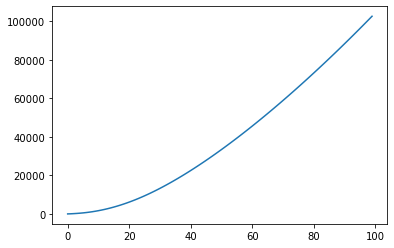

In [45]:
plt.plot(avg_loss)

In [133]:
def evaluateL2O(optimizer_obj, optimizee_cls, num_functions, iterations):
    
    meta_opt = optimizer_obj
    avg_loss_funcs = torch.zeros(size=(num_functions, iterations))
    for n_func in tqdm(range(num_functions)):
        
        quad_cls = optimizee_cls(seed=2*n_func)
        
        # Compute global loss
        loss_unroll, _ = learn(meta_opt, 
                                   quad_cls, 
                                   unroll_steps=iterations, 
                                   retain_graph_flag=True)

        avg_loss_funcs[n_func, :] = torch.tensor(loss_unroll)

    return avg_loss_funcs.mean(axis=0)

In [134]:
eval_loss = evaluateL2O(optimizer_obj = meta_opt, 
                                        optimizee_cls = Quadratic, 
                                        num_functions = 10, 
                                        iterations = 100)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.30s/it]


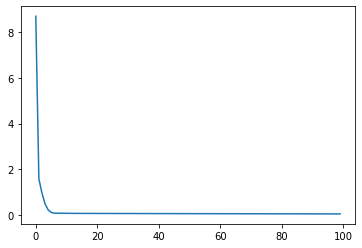

In [135]:
plt.plot(eval_loss)

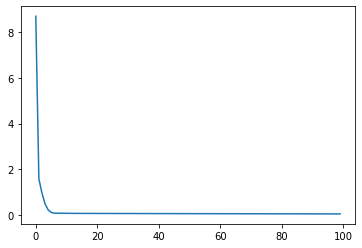

In [131]:
plt.plot(eval_loss)

In [132]:
eval_loss

tensor([8.6904, 1.5837, 0.9689, 0.4922, 0.2324, 0.1200, 0.0871, 0.0816, 0.0809,
        0.0803, 0.0789, 0.0776, 0.0764, 0.0756, 0.0750, 0.0746, 0.0742, 0.0738,
        0.0734, 0.0731, 0.0728, 0.0725, 0.0722, 0.0718, 0.0715, 0.0712, 0.0709,
        0.0706, 0.0703, 0.0700, 0.0697, 0.0694, 0.0691, 0.0688, 0.0686, 0.0683,
        0.0680, 0.0677, 0.0674, 0.0671, 0.0668, 0.0666, 0.0663, 0.0660, 0.0657,
        0.0654, 0.0652, 0.0649, 0.0646, 0.0643, 0.0641, 0.0638, 0.0635, 0.0633,
        0.0630, 0.0627, 0.0625, 0.0622, 0.0619, 0.0617, 0.0614, 0.0612, 0.0609,
        0.0607, 0.0604, 0.0601, 0.0599, 0.0596, 0.0594, 0.0591, 0.0589, 0.0586,
        0.0584, 0.0581, 0.0579, 0.0577, 0.0574, 0.0572, 0.0569, 0.0567, 0.0565,
        0.0562, 0.0560, 0.0557, 0.0555, 0.0553, 0.0550, 0.0548, 0.0546, 0.0543,
        0.0541, 0.0539, 0.0537, 0.0534, 0.0532, 0.0530, 0.0528, 0.0525, 0.0523,
        0.0521])